### EXPERIMENTAL DESIGN

### Part 2: A/B Testing

Designers at Etsy have created a new landing page in an attempt to improve sign-up rate for local meetups.

The historic sign-up rate for the old landing page is 10%. An improvement in the sign-up rate to only 10.1%, while just a .1% absolute improvement, actually means a lift in conversion of 1% (because the percent change from 10% to 10.1% is 1%). If statistically significant, the new landing page would be considered a success. The product manager will not consider implementing the new page if the lift is not greater than or equal to 1%.

Your task is to determine if the new landing page can provide a 1% or more lift to the sign-up rate. You are also given the understanding that there is a very different user base on weekends and a significant amount of the revenue comes from those weekend users.



Building hyothesis testing, a moment before to consider what is the actual business queston: 
***if the new landing page can provide a 1% or more lift to the sign-up rate***


Consider the equavalent of 1% increase of 10%. We are actually speaking about

1% * 10%(0.01 * 0.1) improvement which is 0.001



- Ho: pa - po <= 0.001 No difference.
- Ha: pa - p0  > 0.001 new design presents higher conversion rate. 
- One tailed because we are interested in improvement in accordance to historical data(increased power)

Two sample z-test on proportions to see if the 1% lift is by random chance or not. 

We could randomly divert 50% of incoming users to 
the new page, and direct the other 50% of users to the old page. 
And sending users 
to both webpages at the same time allows us to account for the dependency of signup rates
on time and day of the week (as opposed to, e.g., testing one page on the weekend
and the other page on weekdays, which would be totally confounded by day of the
week!). We should keep in mind that it's possible for one landing page to be better on 
weekdays while the other is better on weekends since we have prior information that 
weekday and weekend populations are distinct. In light of this we might consider 
carrying out two tests -- one for weekdays and one for weekends -- and entertain the 
notion of different websites for the weekdays and weekends.

In [187]:
# will need these
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from z_test.z_test import z_test

Why is it useful to report the change in conversion in terms of lift instead of absolute difference in conversion?

Conversion lift provides a measure of relative improvement, as opposed to
absolute improvement.  When we do classical statistical hypothesis testing 
we are examining the statistical significance of *differences* between 
statistics in an absolute sense.  But not all differences of the same size
have the same *impact* on a business.  Lift on the other had shows you
improvement (or decline) relative to your current performance levels.

Lets work with actual data now. Imagine that we ran a pilot experiment for day1(Tuesday).

Import the data to the df.

In [188]:
df = pd.read_csv('data/experiment.csv')

Lets have a look.

In [189]:
df.head()

,user_id,ts,ab,landing_page,converted
0,4040615247,1.356998e+09,treatment,new_page,0
1,4365389205,1.356998e+09,treatment,new_page,0
2,4256174578,1.356998e+09,treatment,new_page,0
3,8122359922,1.356998e+09,control,old_page,0
4,6077269891,1.356998e+09,control,old_page,0


Lets see if there are duplicates or not

In [190]:
df.user_id.value_counts().unique()  # oh there they are, what should we do?

array([2, 1])

In [191]:
# df.drop_duplicates(subset = "user_id",keep= False, inplace = True)

In [192]:
# df.user_id.value_counts().unique()  # Not on my watch...

In [193]:
df.shape

(191148, 5)

 If customers are in the treatment group they shall see the new page else they shall see the old page. Our dataset actually included rows which stands for the oposite condition of this argument. Nevertheles we got rid of them as we used drop_droplicates. Following piece of code also gets rid of the unwanted condition.

In [194]:
df = df[(df.ab == 'treatment') & (df.landing_page == 'new_page')|(df.ab == 'control') & (df.landing_page == 'old_page')]

In [195]:
df.shape

(186389, 5)

### Z-test 

Lets calculate a p-value for a 1% lift from using the new page compare to the old page.

Using z_test we may need to highlight some assumptions. 

We will need to Interpret the p-value as a result of z-test which will give us direction about the decision between the new or the old page.

In [196]:
def calc_conversion_rate(data, page_type):
    """Counts proportion of total visits resulting in a conversion
    Parameters
    ----------
    data: Pandas DataFrame
        A/B testing storage DataFrame with columns 'converted' (1=yes, 0=no)
        and 'landing_page' with values "new_page" or "old_page"
    page_type: str ("new" or "old")
        corresponding to the "new_page"/"old_page"
    Returns
    -------
    float: proportion of total visits converted for input page_type
    """

    total_vis = data[data['landing_page'] == page_type + '_page']
    converted = total_vis[total_vis['converted'] == 1].shape[0]
    return float(converted) / total_vis.shape[0], total_vis.shape[0]

In [197]:
new_cr = calc_conversion_rate(df, "new")
new_cr

(0.09968192186159416, 95574)

In [198]:
old_cr = calc_conversion_rate(df, "old")
old_cr

(0.09964212960414029, 90815)

With the assumption of the two proportions are equal.


`z_score = (ctr_new - ctr_old - effect_size) / se`


`se = sqrt(conversion * (1 - conversion) * (1 / nobs_old + 1 / nobs_new))`

with `conversion` being the overall conversion rate averaging across pages.

In [199]:
increase_ratio = (new_cr[0] - old_cr[0]) / old_cr[0]
increase_ratio

0.00039935173617787733

The conversion rates for new page are 0.00039* higher compared to that of old page. 
Now we need to check if the difference is statistically significant.(eh I don't think so :)
How do we do that?



Okay simply getting the p-value is easy. So to be more even more accurate about our analisis, how about getting p-values for each and every hour of the day?

In [200]:
def plot_pval(data):
    """plots p-value based on hourly testing of running A/B test
    Parameters
    ----------
    data: Pandas DataFrame
        A/B testing storage DataFrame with columns 'hour' converted' and 'landing_page'
    Returns
    -------
    None: A plot is produced buy no axis object is returned
    """

    pval_lst = []
    datetime = data.ts.astype('datetime64[s]')
    hour = datetime.apply(lambda x: x.hour)
    data['hour'] = hour
    # Run the test as the data accumulates hourly
    for hr in hour.unique():
        hr_data = data[data['hour'] <= hr]
        # data for old landing page
        old = hr_data[hr_data['landing_page'] == 'old_page']['converted']
        old_nrow = old.shape[0]
        old_conversion = old.mean()
        # data for new landing page
        new = hr_data[hr_data['landing_page'] == 'new_page']['converted']
        new_nrow = new.shape[0]
        new_conversion = new.mean()
        # Run the z-test
        p_val = z_test(old_conversion, new_conversion,
                       old_nrow, new_nrow, effect_size=0.001,
                       two_tailed=True, alpha=.05)
        pval_lst.append(p_val[1])

    # Make the plot
    plt.plot(pval_lst, marker='o')
    plt.ylabel('p-value', fontweight='bold', fontsize=14)
    plt.xlabel('Hour in the day', fontweight='bold', fontsize=14)
    plt.axhline(0.05, linestyle='--', color='r')

z-score: 0.5364599453482073, p-value: 0.5916407114301225, reject null: False
z-score: 0.3433997327799706, p-value: 0.7312977605307831, reject null: False
z-score: 0.5994611696032183, p-value: 0.5488653966277077, reject null: False
z-score: 0.5562677616353544, p-value: 0.5780278223400872, reject null: False
z-score: 0.37718605754374995, p-value: 0.706035340889885, reject null: False
z-score: 0.4976825053001899, p-value: 0.6187078408458233, reject null: False
z-score: -0.1129539398684361, p-value: 0.9100670720900992, reject null: False
z-score: -0.08019298224368922, p-value: 0.9360837715456669, reject null: False
z-score: 0.017790064149429817, p-value: 0.9858063311672434, reject null: False
z-score: -0.6801761051390897, p-value: 0.4963929603079378, reject null: False
z-score: -0.8008499531901787, p-value: 0.4232185160925157, reject null: False
z-score: -0.6195274608033423, p-value: 0.5355689371524206, reject null: False
z-score: -0.7968141491026892, p-value: 0.4255589764379981, reject nu

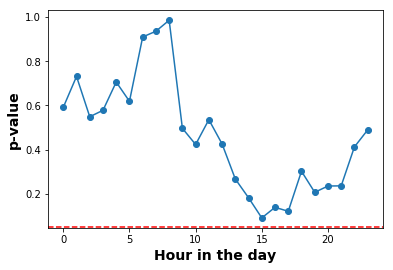

In [201]:
plot_pval(df)

### Conclusion

A p-value is *the probability of observing a test statistic as or more extreme 
than what we saw in the data given the null hypothesis.  At at the 0.05 
significance level, even if the null hypothesis is true, there is a 5% chance 
that we may mistakenly reject it in favor of the alternative. 

Looks like each p-value is higher than 5%, therefore we fail to reject the null hypothesis which states that conversion rates for the old and new page are different. At this point I would try a more interesting design in order to run the test again(depending on the cost).

**Question:** Assume your test was insignificant. Given the setting of the experiment and the context of the problem, why might you be hesitant to make the conclusion to not use the new landing page. What would you do instead?

We know that (a) the user base may be different on the weekend, and (b) that 
sign-up rates are actually driven more by weekend users than weekday users. In 
A/B testing we often have to take into account other confounding factors that
may be influential in driving response and carefully weigh these into our 
analyses informing adoption of a new landing page.  Here, the landing 
page may work for weekend users, but not 'Tuesday' users.

Lets have a closer look, shall we?

Well unfortunatelly we have data only for Tuesday(In fact I converted timestamp to day of the week and somehow we have some monday data as well, but lets keep it as a secret:)

On the other hand what would we do if we had data about each and every day? 

- Run a seperate analisis for weekend data by seperating the dataset with following mock code. And rerun the function called plot_pval in order to see individual p-vals for each hour of Saturday and Sunday which will present significant behavioral differences of customers between weekend and weekdays.

In [167]:
def dayz(x):
    date = time.ctime(int(x))
    day = date[0:3]
    if day in ['Sat','Sun']:
        weekend = 1
    else:
        weekend = 0
    return weekend
    
df['weekend'] = df['ts'].map(dayz)

# df = df.drop(df[df.weekend != 1].index)